# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 17, 19, 42, 13, 340267)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1173659
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.5562605E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [31]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,0.75,0.2,17.102840,310.732025,stockholm
1,2024-11-22 00:00:00+00:00,-3.90,0.1,14.113653,264.144073,stockholm
2,2024-11-18 00:00:00+00:00,2.50,0.0,10.895576,277.594543,stockholm
3,2024-11-19 00:00:00+00:00,0.80,0.0,2.620839,105.945465,stockholm
4,2024-11-24 00:00:00+00:00,1.35,0.3,18.161278,129.369293,stockholm
5,2024-11-23 00:00:00+00:00,-0.40,0.0,13.910169,280.437408,stockholm
6,2024-11-25 00:00:00+00:00,1.20,0.0,18.278645,302.124969,stockholm
7,2024-11-26 00:00:00+00:00,-1.95,0.0,11.435313,331.821503,stockholm
8,2024-11-20 00:00:00+00:00,1.25,0.4,25.932495,13.650437,stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [32]:
import pandas as pd
import datetime

# Ensure batch_data is sorted by date
batch_data = batch_data.sort_values(by='date').reset_index(drop=True)

# Add placeholder columns for lagged features
batch_data['pm2_5_lag_1'] = None
batch_data['pm2_5_lag_2'] = None
batch_data['pm2_5_lag_3'] = None
batch_data['predicted_pm25'] = None

# Fetch the last three days' actual pm25 values
historical_data = air_quality_fg.read()
historical_data_sorted = historical_data.sort_values(by='date', ascending=True)
last_three_days = historical_data_sorted.tail(3)

# Initialize the lagged features using the last three days' pm25 values
batch_data.loc[0, 'pm2_5_lag_1'] = last_three_days.iloc[-1]['pm25']
batch_data.loc[0, 'pm2_5_lag_2'] = last_three_days.iloc[-2]['pm25']
batch_data.loc[0, 'pm2_5_lag_3'] = last_three_days.iloc[-3]['pm25']

# Iteratively predict pm25 for each day
for i in range(len(batch_data)):
    # Prepare features for prediction
    if i > 0:
        # Update lagged features with the last predictions
        batch_data.loc[i, 'pm2_5_lag_1'] = batch_data.loc[i - 1, 'predicted_pm25']
        batch_data.loc[i, 'pm2_5_lag_2'] = batch_data.loc[i - 1, 'pm2_5_lag_1']
        batch_data.loc[i, 'pm2_5_lag_3'] = batch_data.loc[i - 1, 'pm2_5_lag_2']

    # Select features for prediction
    features = batch_data.loc[i, [
        'temperature_2m_mean', 'precipitation_sum', 
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3'
    ]].values.reshape(1, -1)

    # Predict pm25 for the current row
    prediction = retrieved_xgboost_model.predict(features)
    batch_data.loc[i, 'predicted_pm25'] = prediction[0]

# Keep only necessary columns for analysis or storage
batch_data = batch_data[['date', 'temperature_2m_mean', 'precipitation_sum', 
                         'wind_speed_10m_max', 'wind_direction_10m_dominant', 
                         'pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3', 'predicted_pm25']]

# Display the results
print(batch_data)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.72s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2024-11-18 00:00:00+00:00                 2.50                0.0   
1 2024-11-19 00:00:00+00:00                 0.80                0.0   
2 2024-11-20 00:00:00+00:00                 1.25                0.4   
3 2024-11-21 00:00:00+00:00                 0.75                0.2   
4 2024-11-22 00:00:00+00:00                -3.90                0.1   
5 2024-11-23 00:00:00+00:00                -0.40                0.0   
6 2024-11-24 00:00:00+00:00                 1.35                0.3   
7 2024-11-25 00:00:00+00:00                 1.20                0.0   
8 2024-11-26 00:00:00+00:00                -1.95                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant pm2_5_lag_1 pm2_5_lag_2  \
0           10.895576                   277.594543         7.0        16.0   
1            2.620839                   105.945

In [33]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   pm2_5_lag_1                  9 non-null      object             
 6   pm2_5_lag_2                  9 non-null      object             
 7   pm2_5_lag_3                  9 non-null      object             
 8   predicted_pm25               9 non-null      object             
dtypes: datetime64[us, UTC](1), float32(4), object(4)
memory usage: 632.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [34]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,predicted_pm25,street,city,country,days_before_forecast_day
0,2024-11-18 00:00:00+00:00,2.50,0.0,10.895576,277.594543,7.0,16.0,16.0,32.128326,Hornsgatan,stockholm,sweden,1
1,2024-11-19 00:00:00+00:00,0.80,0.0,2.620839,105.945465,32.128326,7.0,16.0,42.460983,Hornsgatan,stockholm,sweden,2
2,2024-11-20 00:00:00+00:00,1.25,0.4,25.932495,13.650437,42.460983,32.128326,7.0,26.202126,Hornsgatan,stockholm,sweden,3
3,2024-11-21 00:00:00+00:00,0.75,0.2,17.102840,310.732025,26.202126,42.460983,32.128326,36.034649,Hornsgatan,stockholm,sweden,4
4,2024-11-22 00:00:00+00:00,-3.90,0.1,14.113653,264.144073,36.034649,26.202126,42.460983,34.562813,Hornsgatan,stockholm,sweden,5
5,2024-11-23 00:00:00+00:00,-0.40,0.0,13.910169,280.437408,34.562813,36.034649,26.202126,35.73357,Hornsgatan,stockholm,sweden,6
6,2024-11-24 00:00:00+00:00,1.35,0.3,18.161278,129.369293,35.73357,34.562813,36.034649,36.167255,Hornsgatan,stockholm,sweden,7
7,2024-11-25 00:00:00+00:00,1.20,0.0,18.278645,302.124969,36.167255,35.73357,34.562813,36.034649,Hornsgatan,stockholm,sweden,8
8,2024-11-26 00:00:00+00:00,-1.95,0.0,11.435313,331.821503,36.034649,36.167255,35.73357,36.300072,Hornsgatan,stockholm,sweden,9


In [35]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   pm2_5_lag_1                  9 non-null      object             
 6   pm2_5_lag_2                  9 non-null      object             
 7   pm2_5_lag_3                  9 non-null      object             
 8   predicted_pm25               9 non-null      object             
 9   street                       9 non-null      object             
 10  city                         9 non-null      object   

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-17 20:16:12,104 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



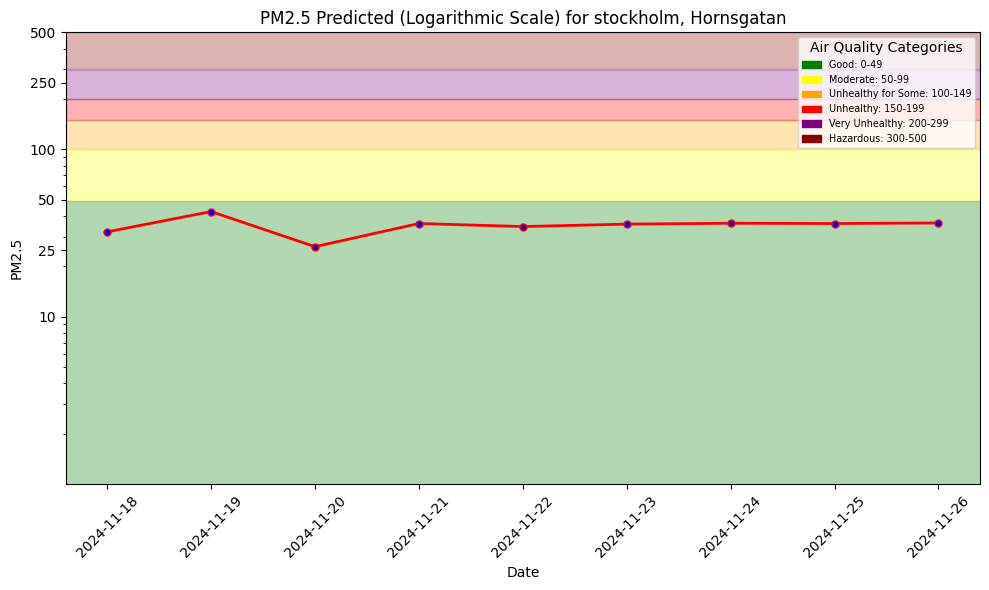

In [36]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()


In [37]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [38]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1173659/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fc1a9f76980>, None)

In [39]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,predicted_pm25,street,city,country,days_before_forecast_day
0,2017-10-07 00:00:00+00:00,6.131084,6.300001,14.332341,343.018829,8.0,9.0,13.0,12.643904,Hornsgatan,stockholm,sweden,1
1,2024-11-18 00:00:00+00:00,2.500000,0.000000,10.895576,277.594543,7.0,16.0,16.0,32.128326,Hornsgatan,stockholm,sweden,1


In [40]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.67s) 


,date,pm25,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,country,city,street,url
0,2022-04-24 00:00:00+00:00,18.0,15.0,22.0,30.0,sweden,stockholm,Hornsgatan,https://api.waqi.info/feed/@10009/
1,2022-09-20 00:00:00+00:00,9.0,6.0,10.0,9.0,sweden,stockholm,Hornsgatan,https://api.waqi.info/feed/@10009/
2,2024-07-24 00:00:00+00:00,22.0,36.0,38.0,31.0,sweden,stockholm,Hornsgatan,https://api.waqi.info/feed/@10009/
3,2018-08-03 00:00:00+00:00,33.0,59.0,50.0,48.0,sweden,stockholm,Hornsgatan,https://api.waqi.info/feed/@10009/
4,2018-07-01 00:00:00+00:00,9.0,32.0,24.0,22.0,sweden,stockholm,Hornsgatan,https://api.waqi.info/feed/@10009/
...,...,...,...,...,...,...,...,...,...
2513,2024-10-16 00:00:00+00:00,16.0,10.0,17.0,14.0,sweden,stockholm,Hornsgatan,https://api.waqi.info/feed/@10009/
2514,2024-03-06 00:00:00+00:00,34.0,44.0,55.0,55.0,sweden,stockholm,Hornsgatan,https://api.waqi.info/feed/@10009/
2515,2022-12-15 00:00:00+00:00,32.0,26.0,22.0,21.0,sweden,stockholm,Hornsgatan,https://api.waqi.info/feed/@10009/
2516,2018-08-01 00:00:00+00:00,50.0,48.0,49.0,55.0,sweden,stockholm,Hornsgatan,https://api.waqi.info/feed/@10009/


In [41]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2017-10-07 00:00:00+00:00,12.643904,13.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

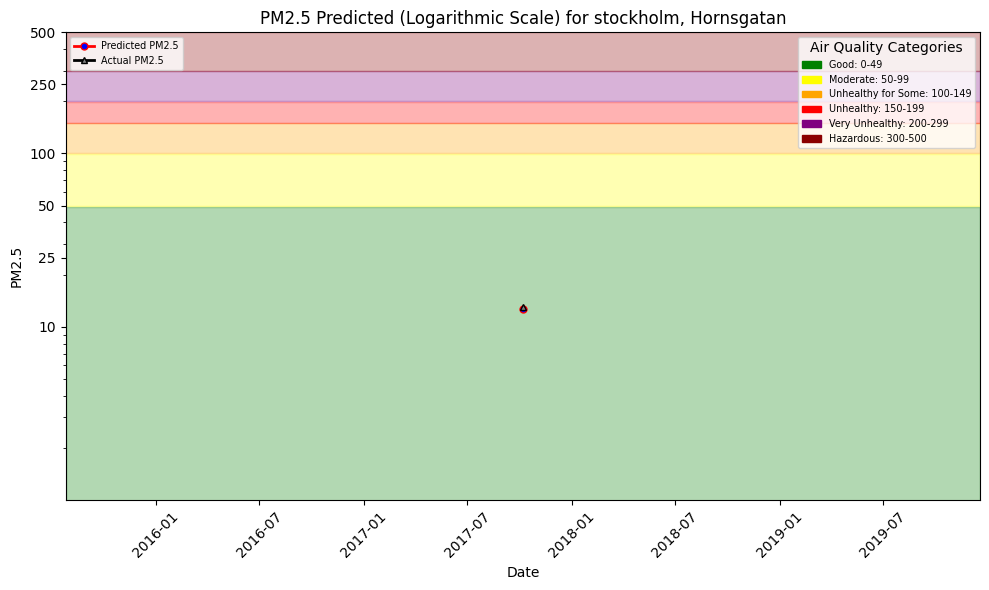

In [42]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---